In [2]:
from mtcnn import MTCNN
import cv2
 
detector = MTCNN()
filename = "./src21/redhead.jpg"

img = cv2.imread(filename) #mtcnn-study-Jolie.png
ix = img.copy()
detections = detector.detect_faces(img)
 
for detection in detections:
    score = detection["confidence"]
    if score > 0.90:
        x, y, w, h = detection["box"]
        detected_face = ix[int(y):int(y+h), int(x):int(x+w)]
        bounding_box = detection['box']
        cv2.rectangle(ix,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0,0,255),
                      2)

for face in detections:
    print(face) 

cv2.imshow("Face",detected_face)
#(this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0)  
#closing all open windows  
cv2.destroyAllWindows()

{'box': [298, 102, 730, 786], 'confidence': 0.9954185485839844, 'keypoints': {'left_eye': (513, 453), 'right_eye': (779, 333), 'nose': (704, 533), 'mouth_left': (679, 735), 'mouth_right': (888, 634)}}


In [3]:
keypoints = detections[0]["keypoints"]
left_eye = keypoints["left_eye"]
right_eye = keypoints["right_eye"]

In [4]:
import numpy as np
import math
from PIL import Image

def euclidean_distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2))    

def alignment_procedure(img, left_eye, right_eye):
    #this function aligns given face in img based on left and right eye coordinates
 
    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye
 
    #-----------------------
    #find rotation direction
 
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1 #rotate same direction to clock
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1 #rotate inverse direction of clock
 
    #-----------------------
    #find length of triangle edges
 
    a = euclidean_distance(np.array(left_eye), np.array(point_3rd))
    b = euclidean_distance(np.array(right_eye), np.array(point_3rd))
    c = euclidean_distance(np.array(right_eye), np.array(left_eye))
 
    #-----------------------
 
    #apply cosine rule
 
    if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
        cos_a = (b*b + c*c - a*a)/(2*b*c)
        angle = np.arccos(cos_a) #angle in radian
        angle = (angle * 180) / math.pi #radian to degree
 
    #-----------------------
    #rotate base image
 
    if direction == -1:
        angle = 90 - angle
 
    img = Image.fromarray(img)
    img = np.array(img.rotate(direction * angle))
 
    #-----------------------
 
    return img #return img anyway

# define a function for horizontally  
# concatenating images of different 
# heights  
def hconcat_resize(img_list,size,interpolation= cv2.INTER_CUBIC): 
      # take minimum hights 
    h, w = size 
      
    # image resizing  
    im_list_resize = [cv2.resize(img,(h,w)) for img in img_list] 
      
    # return final image 
    return cv2.hconcat(im_list_resize) 

In [7]:
im = alignment_procedure(img, left_eye, right_eye)
#im_h = cv2.hconcat([img, im]) 

# function calling 
img_h_resize = hconcat_resize([img, im],(224,224)) 

# save the output image 
cv2.imwrite('./out_imgs/{}_aligned.png'.format(filename.split("src21/")[1].split(".")[0]), im) 
# show the output image 
cv2.imshow("Aligned Face",img_h_resize)
#(this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0)  
  
#closing all open windows  
cv2.destroyAllWindows()  

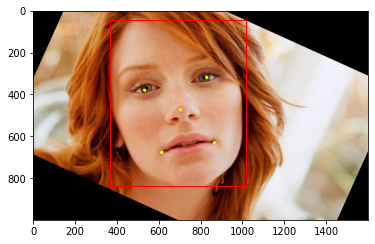

In [8]:
# face detection with mtcnn on a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
import cv2
from PIL import Image 

# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
    # print(filename)
    # load the image
    data = pyplot.imread(filename)
    # Opens a image in RGB mode 
    im = Image.open(filename)  #crop
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    filename = filename.split("./out_imgs/")[1]  #removing ./out_imgs/
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        cropped = im.crop((x,y,x+width,y+height))
        #Display the cropped portion
        cropped.show()
        cropped.save('./out_imgs/{}_cropped.png'.format(filename.split(".")[0]))
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = Circle(value, radius=5, color='yellow')
            ax.add_patch(dot)
    # show the plot
    pyplot.axis('off')
    pyplot.savefig('./out_imgs/{}_bbox.png'.format(filename.split(".")[0]),dpi=100,bbox_inches='tight')
    pyplot.axis('on')
    pyplot.show()

# display faces on the original image
alignedfile='./out_imgs/{}_aligned.png'.format(filename.split("src21/")[1].split(".")[0])
img_a = cv2.imread(alignedfile)
detections_a = detector.detect_faces(img_a)
draw_image_with_boxes(alignedfile, detections_a) 